In [1]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings(action="ignore")

from hossam.util import *
from hossam.plot import *
from hossam.classification import *
from hossam.tensor import *
import re

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2024-04-16 00:19:43.207672: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
origin = my_read_excel(
    "https://data.hossam.kr/edadata/titanic.xlsx",
    index_col="PassengerId",
    categories=["Survived", "Pclass", "Sex", "Embarked"],
    info=False,
)


상위 5개 행
+---------------+------------+----------+-----------------------------------------------------+--------+-------+---------+---------+------------------+---------+---------+------------+
|   PassengerId |   Survived |   Pclass | Name                                                | Sex    |   Age |   SibSp |   Parch | Ticket           |    Fare | Cabin   | Embarked   |
|---------------+------------+----------+-----------------------------------------------------+--------+-------+---------+---------+------------------+---------+---------+------------|
|             1 |          0 |        3 | Braund, Mr. Owen Harris                             | male   |    22 |       1 |       0 | A/5 21171        |    7.25 | nan     | S          |
|             2 |          1 |        1 | Cumings, Mrs. John Bradley (Florence Briggs Thayer) | female |    38 |       1 |       0 | PC 17599         | 71.2833 | C85     | C          |
|             3 |          1 |        3 | Heikkinen, Miss. Laina  

## #02. 데이터 전처리

01. 생존 여부에 따른 평균 나이로 결측치 치환
02. 히스토그램 구간에 따라 나이를 명목형으로 변환
03. 객실 유무에 따른 명목형 변수 생성
04. 가족 구성원 수 파생변수 생성
05. 혼자 탑승했는지에 대한 파생변수 생성
06. 생존 여부에 따른 탑승지 최빈값으로 결측치 치환
07. 생존 여부에 따른 운임요금 평균으로 결측치 치환
08. 이름으로부터 호칭 파생변수 생성
09. 데이터 라벨링
10. 운임요금 사분위수 구간에 따른 명목형 파생변수 생성
11. 불필요한 컬럼 제거


In [3]:
df = origin.copy()

# 1. 생존 여부에 따른 평균 나이로 결측치 치환
mean_age_df = df[["Survived", "Age"]].groupby("Survived").mean()

for i in mean_age_df.index:
    mean_age = round(mean_age_df.loc[i]["Age"], 0)
    expr = (df["Survived"] == i) & (df["Age"].isna())
    df.loc[expr, "Age"] = df.loc[expr, "Age"].fillna(mean_age)

# 2. 히스토그램 구간에 따라 나이를 명목형으로 변환
hist, bins = np.histogram(df["Age"], bins=5)

df2 = df.copy()
df2.loc[df2["Age"] <= 16, "Age"] = 0
df2.loc[(df2["Age"] > 16) & (df2["Age"] <= 32), "Age"] = 1
df2.loc[(df2["Age"] > 32) & (df2["Age"] <= 48), "Age"] = 2
df2.loc[(df2["Age"] > 48) & (df2["Age"] <= 64), "Age"] = 3
df2.loc[df2["Age"] > 64, "Age"] = 4

# 3. 객실 유무에 따른 명목형 변수 생성
df2["Has_Cabin"] = df2["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
df2["Has_Cabin"].value_counts()

# 4. 가족 구성원 수 파생변수 생성
df2["FamilySize"] = df2["SibSp"] + df2["Parch"] + 1

# 5. 혼자 탑승했는지에 대한 파생변수 생성
df2["IsAlone"] = 0
df2.loc[df2["FamilySize"] == 1, "IsAlone"] = 1

# 6. 생존 여부에 따른 탑승지 최빈값으로 결측치 치환
most_embarked_df = df2[["Survived", "Embarked"]].groupby("Survived").agg(Series.mode)

for i in most_embarked_df.index:
    most = most_embarked_df.loc[i]["Embarked"]
    expr = (df2["Survived"] == i) & (df2["Embarked"].isna())
    df2.loc[expr, "Embarked"] = df2.loc[expr, "Embarked"].fillna(most)

# 7. 생존 여부에 따른 운임요금 평균으로 결측치 치환
mean_fare_df = df2[["Survived", "Fare"]].groupby("Survived").mean()

for i in mean_fare_df.index:
    mean_fare = mean_fare_df.loc[i]["Fare"]
    expr = (df2["Survived"] == i) & (df2["Fare"].isna())
    df2.loc[expr, "Fare"] = df2.loc[expr, "Fare"].fillna(mean_fare)


# 8. 이름으로부터 호칭 파생변수 생성
def get_title(name):
    title_search = re.search(" ([A-Za-z]+)\.", name)

    if title_search:
        return title_search.group(1)

    return ""


df2["Title"] = df2["Name"].apply(get_title)

df2["Title"] = df2["Title"].replace(
    [
        "Rev",
        "Dr",
        "Mlle",
        "Major",
        "Col",
        "Countess",
        "Capt",
        "Ms",
        "Sir",
        "Lady",
        "Mme",
        "Don",
        "Jonkheer",
        "Dona",
    ],
    "Rare",
)

# 9. 데이터 라벨링
df3 = my_labelling(df2, "Title", "Embarked", "Sex")

# 10. 운임요금 사분위수 구간에 따른 명목형 파생변수 생성
df3.loc[df3["Fare"] <= 7.9, "Fare"] = 0
df3.loc[(df2["Fare"] > 7.9) & (df3["Fare"] <= 14.5), "Fare"] = 1
df3.loc[(df3["Fare"] > 14.5) & (df3["Fare"] <= 31.3), "Fare"] = 2
df3.loc[df3["Fare"] > 31.3, "Fare"] = 3

# 11. 불필요한 컬럼 제거
drop_elements = ["Name", "Ticket", "Cabin", "SibSp", "Parch", "Pclass"]
df4 = df3.drop(drop_elements, axis=1)

my_pretty_table(df4.head())

+---------+---------+
| Title   |   label |
|---------+---------|
| Master  |       0 |
| Miss    |       1 |
| Mr      |       2 |
| Mrs     |       3 |
| Rare    |       4 |
+---------+---------+
+------------+---------+
| Embarked   |   label |
|------------+---------|
| C          |       0 |
| Q          |       1 |
| S          |       2 |
+------------+---------+
+--------+---------+
| Sex    |   label |
|--------+---------|
| female |       0 |
| male   |       1 |
+--------+---------+
+---------------+------------+-------+-------+--------+------------+-------------+--------------+-----------+---------+
|   PassengerId |   Survived |   Sex |   Age |   Fare |   Embarked |   Has_Cabin |   FamilySize |   IsAlone |   Title |
|---------------+------------+-------+-------+--------+------------+-------------+--------------+-----------+---------|
|             1 |          0 |     1 |     1 |      0 |          2 |           0 |            2 |         0 |       2 |
|             2 |    

In [4]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    1309 non-null   category
 1   Sex         1309 non-null   int64   
 2   Age         1309 non-null   float64 
 3   Fare        1309 non-null   float64 
 4   Embarked    1309 non-null   int64   
 5   Has_Cabin   1309 non-null   int64   
 6   FamilySize  1309 non-null   int64   
 7   IsAlone     1309 non-null   int64   
 8   Title       1309 non-null   int64   
dtypes: category(1), float64(2), int64(6)
memory usage: 93.4 KB


In [5]:
df4["Survived"] = df4["Survived"].astype("int")
x_train, x_test, y_train, y_test = my_train_test_split(df4, yname="Survived")
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1047, 8), (262, 8), (1047,), (262,))

Trial 12 Complete [00h 00m 01s]
val_acc: 0.7786259651184082

Best val_acc So Far: 0.805343508720398
Total elapsed time: 00h 00m 15s
+-------+----------+----------+
|       |      acc |     loss |
|-------+----------+----------|
| train |  0.86915 | 0.351719 |
| test  | 0.877863 | 0.333227 |
+-------+----------+----------+


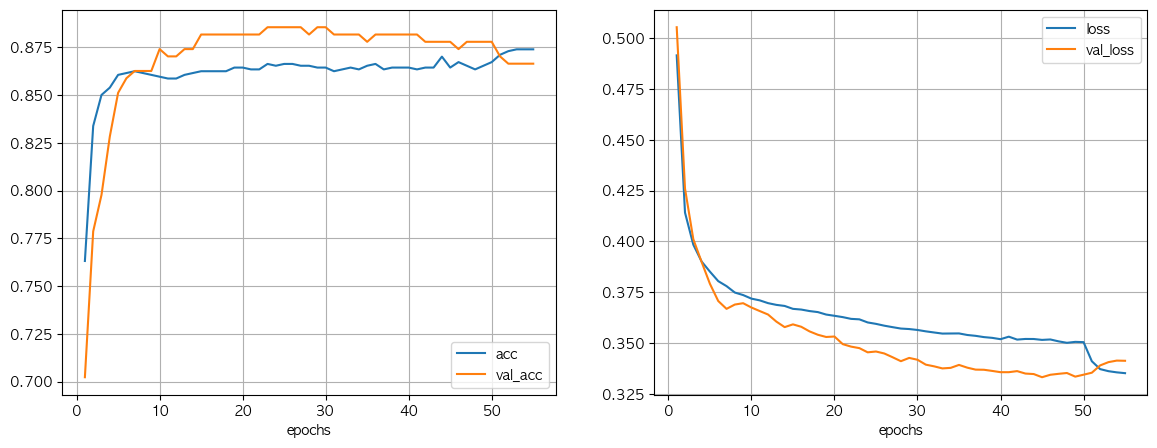

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |      0.86915 |     0.877863 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.853372 |     0.862069 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.769841 |     0.862069 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |    0.0747384 |     0.109589 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.925262 |     0.890411 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.809458 |     0.862069 | 정밀도와 재현율의 조화평균                                |
+-------------------+

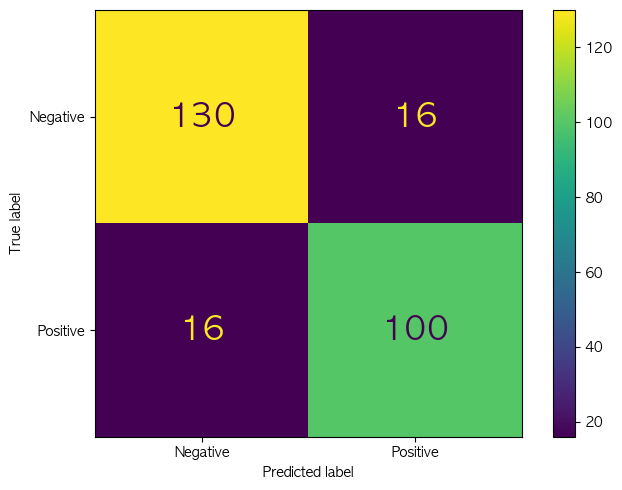


[Roc Curve]
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step


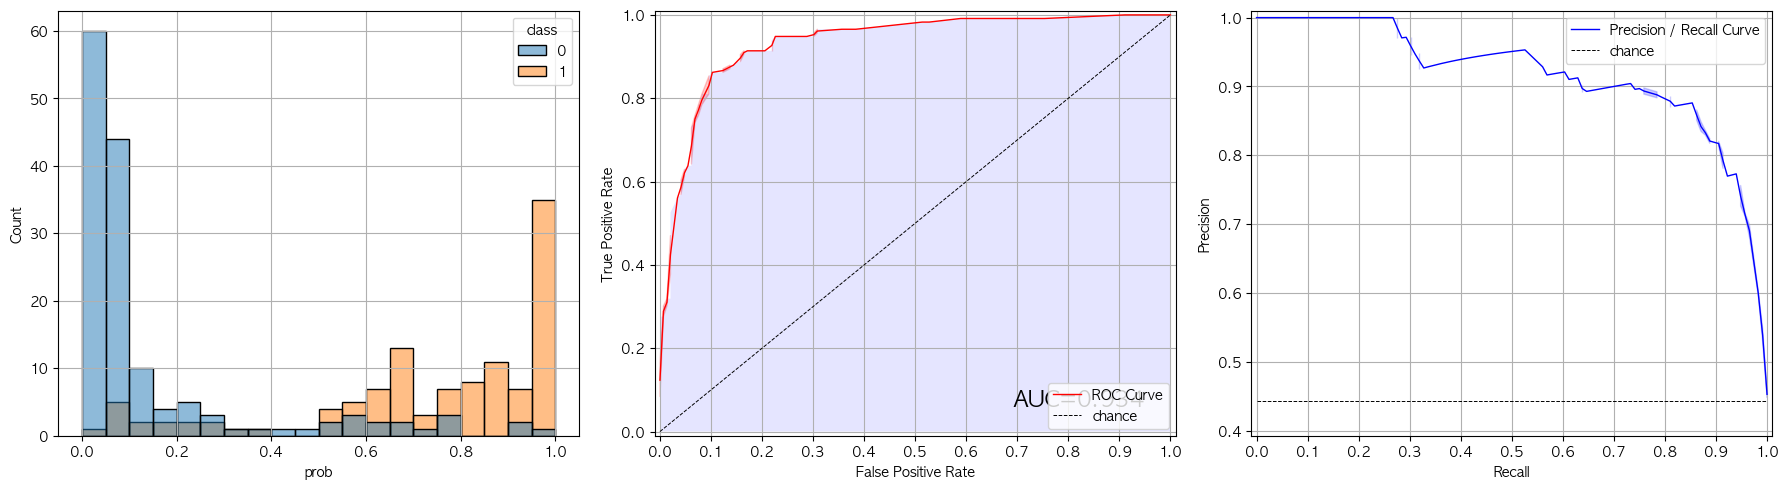


[학습곡선]
이 데이터는 학습곡선을 도출하는데 적합하지 않습니다.


+----+------------+------------+---------+
|    | 종속변수   | 독립변수   |     VIF |
|----+------------+------------+---------|
|  0 | Survived   | Sex        | 2.42511 |
|  1 | Survived   | Age        | 5.18348 |
|  2 | Survived   | Fare       |  5.5773 |
|  3 | Survived   | Embarked   |  4.2441 |
|  4 | Survived   | Has_Cabin  | 2.14215 |
|  5 | Survived   | FamilySize | 3.65847 |
|  6 | Survived   | IsAlone    |  3.4828 |
|  7 | Survived   | Title      | 5.85113 |
+----+------------+------------+---------+


<Sequential name=sequential_1, built=True>

In [6]:
my_tf_sigmoid(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)